In [1]:
import pandas as pd
import numpy as np

## Import dataset

In [2]:
data = pd.read_csv("dataset/MBA.csv")

In [3]:
data.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


## EDA

In [4]:
len(data)

6194

In [5]:
data.isnull().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

In [6]:
numerical = ["gpa", "gmat", "work_exp"]
categorical = ["gender", "international", "major", "race", "work_industry", "admission"]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

### Explore numerical values

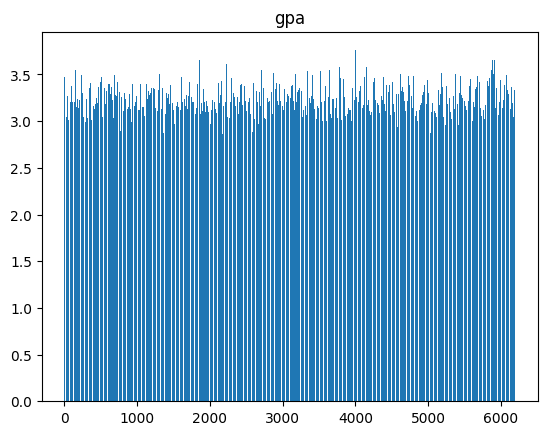

max value: 3.77
min value: 2.65
mean: 3.2507135938004517
median: 3.25


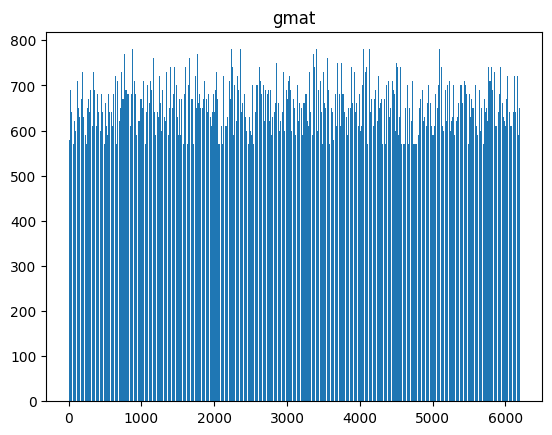

max value: 780.0
min value: 570.0
mean: 651.0929932192445
median: 650.0


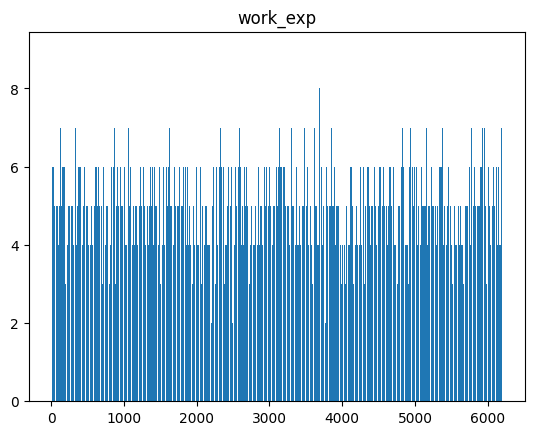

max value: 9.0
min value: 1.0
mean: 5.0169518889247655
median: 5.0


In [8]:
for category in numerical:
    plt.bar(data.application_id, data[category])
    plt.title(category)
    plt.show()
    print(f"max value: {np.max(data[category])}")
    print(f"min value: {np.min(data[category])}")
    print(f"mean: {data[category].mean()}")
    print(f"median: {data[category].median()}")

Text(0.5, 1.0, 'GPA distribution')

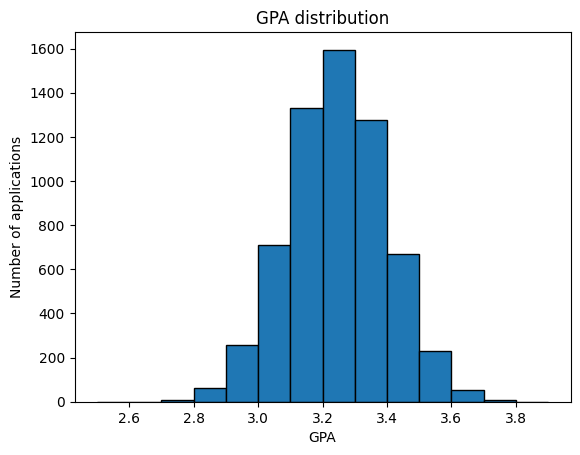

In [9]:
bins = np.arange(2.5, 4, 0.10)
plt.hist(data.gpa, bins=bins, edgecolor='black')
plt.xlabel('GPA')
plt.ylabel('Number of applications')
plt.title("GPA distribution")

(array([ 634., 1393., 1795., 1462.,  676.,  234.]),
 array([550., 590., 630., 670., 710., 750., 790.]),
 <BarContainer object of 6 artists>)

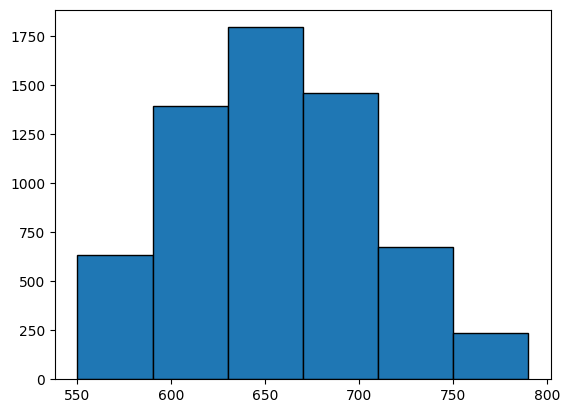

In [10]:
bins = np.arange(550, 800, 40)
plt.hist(data.gmat, bins=bins, edgecolor='black')

Text(0.5, 1.0, 'Work experience distribution')

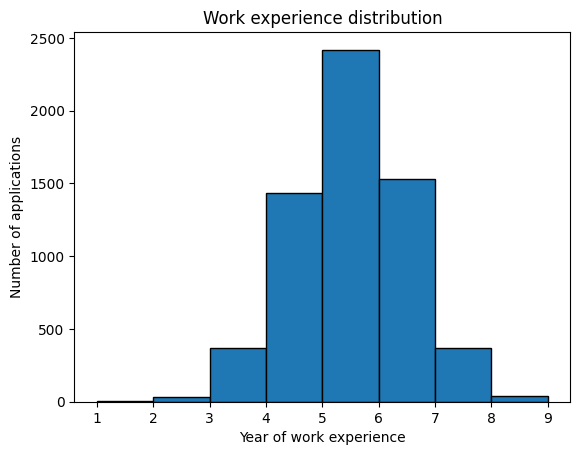

In [11]:
bins = np.arange(1, 10, 1)
plt.hist(data.work_exp, bins=bins, edgecolor='black')
plt.xlabel('Year of work experience')
plt.ylabel('Number of applications')
plt.title("Work experience distribution")

### Explore categorical values

In [12]:
data[categorical].nunique()

gender            2
international     2
major             3
race              5
work_industry    14
admission         2
dtype: int64

In [13]:
from collections import Counter

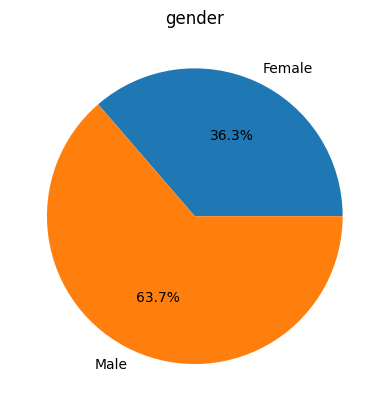

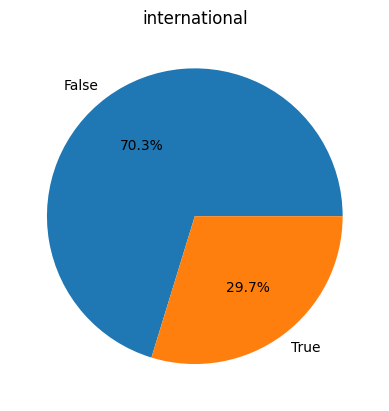

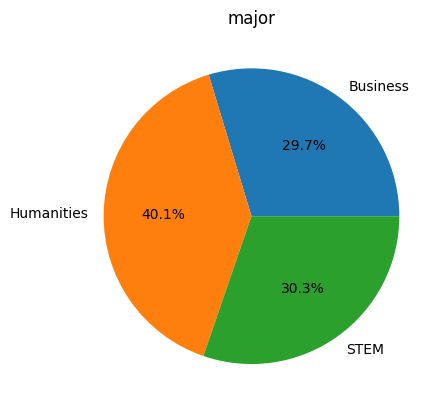

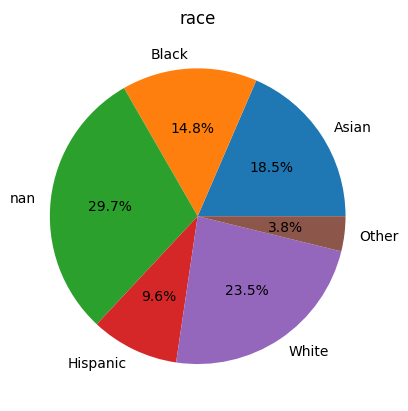

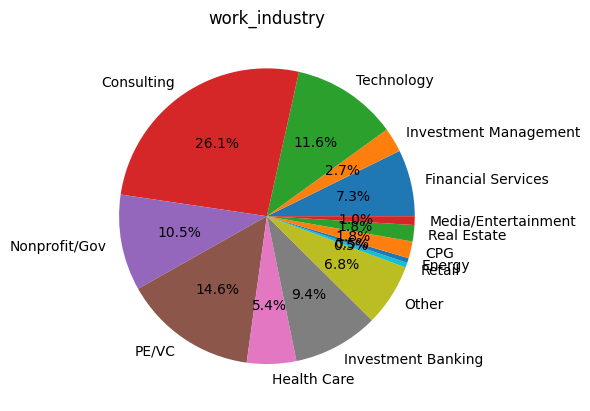

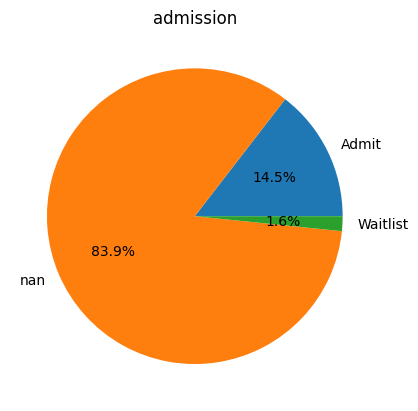

In [14]:
for category in categorical:
    counts_column = Counter(data[category])
    labels = list(counts_column.keys())
    values = list(counts_column.values())
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(category)
    plt.show()

### Prepare admission column

for training and evaluational purposes "Waitlist" in the admission column will be replaced by "Admit"

In [15]:
data.fillna(value={'race':  "Unknown"}, inplace=True)

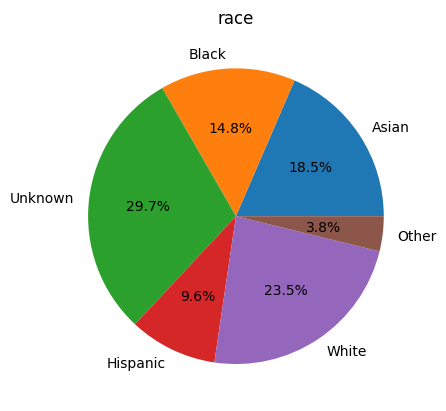

In [16]:
counts_column = Counter(data["race"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("race")
plt.show()

In [17]:
data.loc[data["admission"] == "Waitlist", "admission"] = "Admit"

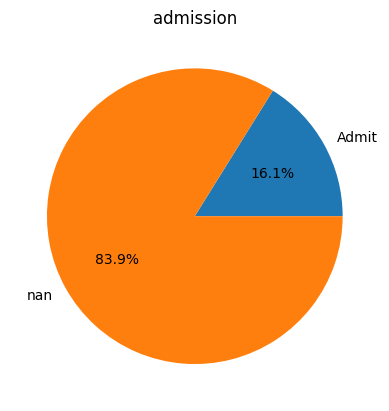

In [18]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

In [19]:
data["admission"] = (data["admission"] == "Admit").astype(int)

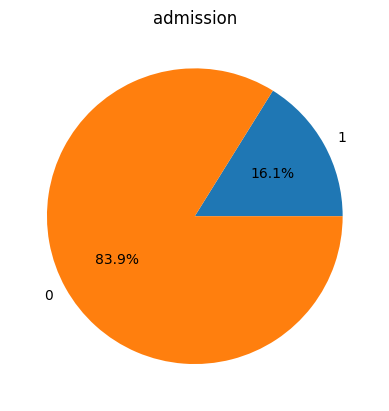

In [20]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

## Feature importance

In [21]:
categorical = ["gender", "international", "major", "race", "work_industry"]

In [22]:
from IPython.display import display

In [23]:
overall_admision = data.admission.mean()
overall_admision

np.float64(0.16144656118824668)

In [24]:
for category in categorical:
    print(category)
    data_category = data.groupby(category).admission.agg(mean='mean', count='count')
    data_category['difference'] = data_category['mean'] - overall_admision
    data_category['risk_ratio'] = data_category['mean'] / overall_admision
    display(data_category)
    print()

gender


,mean,count,difference,risk_ratio
gender,,,,
Female,0.222124,2251,0.060677,1.375833
Male,0.126807,3943,-0.034640,0.785443



international


,mean,count,difference,risk_ratio
international,,,,
False,0.159007,4352,-0.002439,0.984892
True,0.167210,1842,0.005763,1.035696



major


,mean,count,difference,risk_ratio
major,,,,
Business,0.158868,1838,-0.002578,0.984030
Humanities,0.164450,2481,0.003003,1.018602
STEM,0.160000,1875,-0.001447,0.991040



race


,mean,count,difference,risk_ratio
race,,,,
Asian,0.184830,1147,0.023383,1.144837
Black,0.098253,916,-0.063193,0.608581
Hispanic,0.117450,596,-0.043997,0.727483
Other,0.210970,237,0.049524,1.306751
Unknown,0.167210,1842,0.005763,1.035696
White,0.185440,1456,0.023993,1.148613



work_industry


,mean,count,difference,risk_ratio
work_industry,,,,
CPG,0.184211,114,0.022764,1.141000
Consulting,0.158740,1619,-0.002707,0.983235
Energy,0.093750,32,-0.067697,0.580688
Financial Services,0.210643,451,0.049196,1.304723
Health Care,0.143713,334,-0.017734,0.890156
Investment Banking,0.155172,580,-0.006274,0.961138
Investment Management,0.222892,166,0.061445,1.380590
Media/Entertainment,0.152542,59,-0.008904,0.944847
Nonprofit/Gov,0.150538,651,-0.010909,0.932430


In [25]:
from sklearn.metrics import mutual_info_score

In [26]:
data[categorical].apply(lambda x: mutual_info_score(x, data.admission)).sort_values()

major            0.000023
international    0.000052
work_industry    0.001364
race             0.004419
gender           0.007527
dtype: float64

In [27]:
data[numerical].corrwith(data.admission).sort_values()

work_exp    0.006821
gpa         0.289618
gmat        0.353645
dtype: float64

## KFold

In [28]:
def split_train_val(full_data, train_idx, val_idx):
    data_train = full_data.iloc[train_idx]
    data_val = full_data.iloc[val_idx]
    y_train = data_train.admission.values
    y_val = data_val.admission.values
    
    del data_train["admission"]
    del data_val["admission"]
    return data_train, data_val, y_train, y_val

## Split data

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
data_full_train, data_test = train_test_split(data, test_size=0.2)
data_train, data_val = train_test_split(data_full_train, test_size=0.25)

In [31]:
print(f"train: {len(data_train)}, val: {len(data_val)}, test: {len(data_test)}")

train: 3716, val: 1239, test: 1239


In [32]:
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [33]:
y_train = data_train.admission.values
y_val = data_val.admission.values
y_test = data_test.admission.values

In [34]:
del data_train["admission"]
del data_val["admission"]
del data_test["admission"]

## Features ROC AUC

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

gpa: 0.7288730531289647


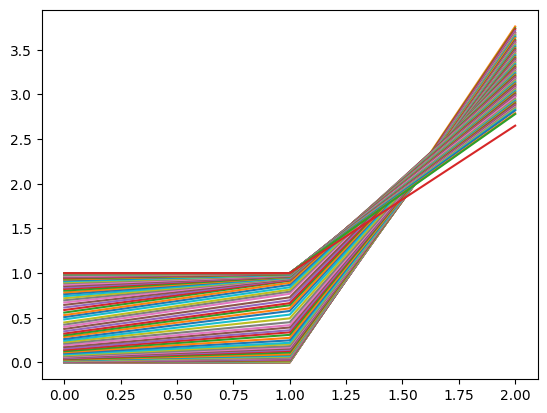

gmat: 0.7762010881907757


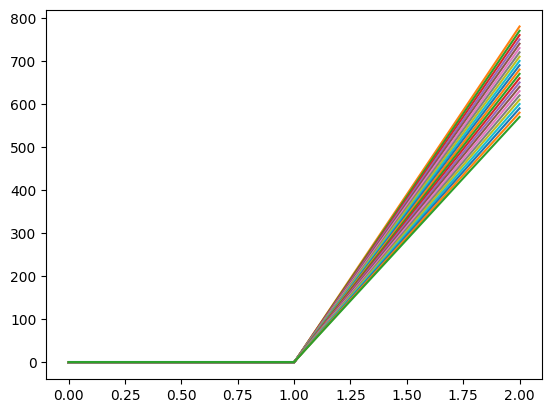

work_exp: 0.5036386973576416


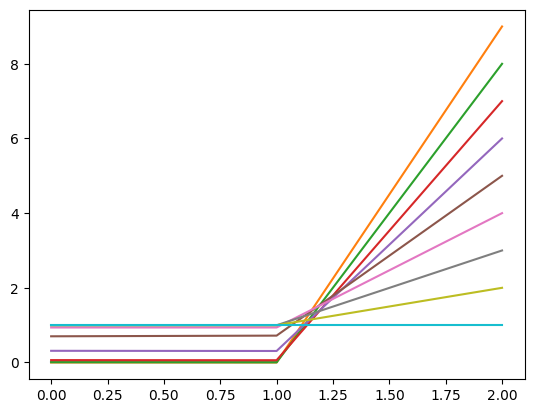

In [36]:
for col in numerical:
    auc = roc_auc_score(data_full_train.admission, data_full_train[col])
    if auc < 0.5:
        auc = roc_auc_score(data_full_train.admission, -data_full_train[col])
    print(f"{col}: {auc}")
    plt.plot(roc_curve(data_full_train.admission, data_full_train[col]))
    plt.show()

In [37]:
features = ["gender", "gpa", "race", "gmat", "work_industry"]

## Train logistic regression

In [38]:
from sklearn.model_selection import KFold

In [39]:
kfold = KFold(n_splits=5, shuffle=True)

In [40]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [41]:
dv = DictVectorizer(sparse=True)

In [42]:
c_values = [0.0000001, 0.00001, 0.001, 0.1, 1, 5, 10, 100]

In [43]:
def train_model(c, features):
    scores = []
    for train_idx, val_idx in kfold.split(data_full_train):
        data_train, data_val, y_train, y_val = split_train_val(data_full_train, train_idx, val_idx)
    
        train_dict = data_train[features].to_dict(orient='records')
        train_X = dv.fit_transform(train_dict)
    
        model = LogisticRegression(solver='liblinear', C=c)
        model.fit(train_X, y_train)
        
        val_dict = data_val[features].to_dict(orient='records')
        val_X = dv.fit_transform(val_dict)
        y_pred = model.predict_proba(val_X)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))
    print(f"c={c}")
    m = np.mean(scores)
    s = np.std(scores)
    print(f"mean: {m}, std: {s}")
    return m, s

#### let's try different values of c

In [44]:
for c in c_values:
    train_model(c, features)

c=1e-07
mean: 0.22846660070597866, std: 0.014707951641711361
c=1e-05
mean: 0.22990069722885279, std: 0.0061600314428963505
c=0.001
mean: 0.3522341979760972, std: 0.021452801152512385
c=0.1
mean: 0.7335528791967868, std: 0.025240414014644677
c=1
mean: 0.7958953010324802, std: 0.021494321145231622
c=5
mean: 0.8071535726021984, std: 0.015125169853217837
c=10
mean: 0.8089620382408486, std: 0.016516816948821088
c=100
mean: 0.8095562994203187, std: 0.009220324264982633


In [45]:
d = {}
for c in range(10, 101, 10):
    m, s = train_model(c, features)
    d[c] = {"mean": m, "std": s}

c=10
mean: 0.8107232323013112, std: 0.011385377354238157
c=20
mean: 0.8090734954589621, std: 0.011969993169241345
c=30
mean: 0.8061802073033242, std: 0.01033926545477
c=40
mean: 0.8097308347491294, std: 0.015299414006812704
c=50
mean: 0.8099868932494054, std: 0.012263507821442057
c=60
mean: 0.8106512639108757, std: 0.014447839219027201
c=70
mean: 0.8095919090277146, std: 0.014493587369149994
c=80
mean: 0.8123426454380664, std: 0.01429550753501199
c=90
mean: 0.8103195001482317, std: 0.01736685509140388
c=100
mean: 0.8128811142393021, std: 0.01422125762782641


In [46]:
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]["mean"], reverse=True))
sorted_d

{100: {'mean': np.float64(0.8128811142393021),
  'std': np.float64(0.01422125762782641)},
 80: {'mean': np.float64(0.8123426454380664),
  'std': np.float64(0.01429550753501199)},
 10: {'mean': np.float64(0.8107232323013112),
  'std': np.float64(0.011385377354238157)},
 60: {'mean': np.float64(0.8106512639108757),
  'std': np.float64(0.014447839219027201)},
 90: {'mean': np.float64(0.8103195001482317),
  'std': np.float64(0.01736685509140388)},
 50: {'mean': np.float64(0.8099868932494054),
  'std': np.float64(0.012263507821442057)},
 40: {'mean': np.float64(0.8097308347491294),
  'std': np.float64(0.015299414006812704)},
 70: {'mean': np.float64(0.8095919090277146),
  'std': np.float64(0.014493587369149994)},
 20: {'mean': np.float64(0.8090734954589621),
  'std': np.float64(0.011969993169241345)},
 30: {'mean': np.float64(0.8061802073033242),
  'std': np.float64(0.01033926545477)}}

In [47]:
sorted_d[10]

{'mean': np.float64(0.8107232323013112),
 'std': np.float64(0.011385377354238157)}

In [48]:
d = {}
for c in c_values:
    m, s = train_model(c, categorical+numerical)
    d[c] = {"mean": m, "std": s}

c=1e-07
mean: 0.22465861036826276, std: 0.031302072066941515
c=1e-05
mean: 0.22616354199471234, std: 0.011784339440389023
c=0.001
mean: 0.455255899293791, std: 0.007597936088748665
c=0.1
mean: 0.7401713944430245, std: 0.025738905041992746
c=1
mean: 0.8029666028180309, std: 0.020675945622274556
c=5
mean: 0.8043762728419575, std: 0.014151792385311803
c=10
mean: 0.80909389663317, std: 0.012299542293351546
c=100
mean: 0.8082938071823541, std: 0.009539125583298143


In [49]:
d = {}
for c in range(5, 101, 5):
    m, s = train_model(c, features)
    d[c] = {"mean": m, "std": s}

c=5
mean: 0.8087840961776683, std: 0.008261130914331912
c=10
mean: 0.8098807520307322, std: 0.014427124591761351
c=15
mean: 0.8116684797116702, std: 0.00843450375821681
c=20
mean: 0.8080131353398909, std: 0.014341367521023258
c=25
mean: 0.8131464871504335, std: 0.009851982880279962
c=30
mean: 0.8079132890829059, std: 0.02258312361473869
c=35
mean: 0.8101716749873138, std: 0.009555977360613642
c=40
mean: 0.8079631553658227, std: 0.01023544740282101
c=45
mean: 0.8097989088382267, std: 0.00494312673368746
c=50
mean: 0.8072577736333274, std: 0.005945331894283312
c=55
mean: 0.8080894762168542, std: 0.012565396119221901
c=60
mean: 0.8111772650075627, std: 0.010223909433487933
c=65
mean: 0.8118293225782642, std: 0.013864922097122225
c=70
mean: 0.8122133499755424, std: 0.01720981560638083
c=75
mean: 0.8079088164854673, std: 0.013571955062685468
c=80
mean: 0.8087931797451713, std: 0.01597759351645065
c=85
mean: 0.8097027597170696, std: 0.013744464189553586
c=90
mean: 0.8113881974813415, std: 0.

In [50]:
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]["mean"], reverse=True))
sorted_d

{25: {'mean': np.float64(0.8131464871504335),
  'std': np.float64(0.009851982880279962)},
 70: {'mean': np.float64(0.8122133499755424),
  'std': np.float64(0.01720981560638083)},
 65: {'mean': np.float64(0.8118293225782642),
  'std': np.float64(0.013864922097122225)},
 15: {'mean': np.float64(0.8116684797116702),
  'std': np.float64(0.00843450375821681)},
 90: {'mean': np.float64(0.8113881974813415),
  'std': np.float64(0.009267656159593487)},
 60: {'mean': np.float64(0.8111772650075627),
  'std': np.float64(0.010223909433487933)},
 100: {'mean': np.float64(0.8102788496595247),
  'std': np.float64(0.017259355071962766)},
 35: {'mean': np.float64(0.8101716749873138),
  'std': np.float64(0.009555977360613642)},
 10: {'mean': np.float64(0.8098807520307322),
  'std': np.float64(0.014427124591761351)},
 45: {'mean': np.float64(0.8097989088382267),
  'std': np.float64(0.00494312673368746)},
 85: {'mean': np.float64(0.8097027597170696),
  'std': np.float64(0.013744464189553586)},
 95: {'mean'

#### train final logistic regression models

In [76]:
full_model_lg_75 = LogisticRegression(solver='liblinear', C=75)

In [77]:
full_train_dict = data_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

full_model_lg_75.fit(X_full_train, y_train)

LogisticRegression(C=75, solver='liblinear')

In [78]:
full_test_dict = data_test.to_dict(orient='records')
X_full_test = dv.fit_transform(full_test_dict)

y_pred = full_model_lg_75.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.7225286960746604)

As we can see from teh roc auc the model overfits to the training data, so we'll train a new model on a smaller number of features

In [54]:
train_dict = data_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = data_val[features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

test_dict = data_test[features].to_dict(orient='records')
X_test = dv.fit_transform(test_dict)

In [55]:
final_model_lg_75 = LogisticRegression(solver='liblinear', C=75)

In [56]:
final_model_lg_75.fit(X_train, y_train)

LogisticRegression(C=75, solver='liblinear')

In [57]:
y_pred = final_model_lg_75.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8322823248375407)

In [58]:
final_model_lg_10 = LogisticRegression(solver='liblinear', C=10)

In [59]:
final_model_lg_10.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [60]:
y_pred = final_model_lg_10.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8292963135413082)

LogisticRegression with C=75 has been the most accurate so far

## Train decision trees

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
depths = list(range(1, 21)) + list(range (25, 50, 5))
depths.append(None)

In [63]:
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)

    y_pred = tree.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'{depth}: {auc}')

1: 0.7585645417713729
2: 0.8293912508333761
3: 0.8396328016821376
4: 0.841389302015488
5: 0.8408174778193753
6: 0.8446894712549362
7: 0.8384712036514694
8: 0.8293476588543002
9: 0.81226985999282
10: 0.8069311246730602
11: 0.7990230268218882
12: 0.7857787578850197
13: 0.7555618236832657
14: 0.7307861941638033
15: 0.7414636648033233
16: 0.7170265141802143
17: 0.6859633827375763
18: 0.6672624237140367
19: 0.683865839273809
20: 0.6588978921996
25: 0.6676470588235294
30: 0.6745576696240833
35: 0.6443509923585824
40: 0.650269244576645
45: 0.6546053643776604
None: 0.63861223652495


In [64]:
best_depths = [3, 4, 5]

In [66]:
min_leaves = list(range(1, 5)) + list(range(10, 31, 5)) + list(range(50, 201, 50))
min_leaves

[1, 2, 3, 4, 10, 15, 20, 25, 30, 50, 100, 150, 200]

In [70]:
scores = []
for depth in best_depths:
    print(f"depth: {depth}")
    d = {}
    for m_l in min_leaves:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=m_l)
        tree.fit(X_train, y_train)

        y_pred = tree.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        d[m_l] = auc
        scores.append((depth, m_l, auc))
    sorted_d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
    print(sorted_d)

depth: 3
{2: np.float64(0.8407097799887173), 3: np.float64(0.8407097799887173), 4: np.float64(0.8407097799887173), 10: np.float64(0.8407097799887173), 15: np.float64(0.8407097799887173), 20: np.float64(0.8407097799887173), 25: np.float64(0.8407097799887173), 30: np.float64(0.8407097799887173), 50: np.float64(0.8407097799887173), 100: np.float64(0.8407097799887173), 150: np.float64(0.8405738755833633), 200: np.float64(0.8405738755833633), 1: np.float64(0.8396328016821376)}
depth: 4
{100: np.float64(0.8479819477921946), 150: np.float64(0.8425739781527258), 10: np.float64(0.8418970203600186), 15: np.float64(0.8418970203600186), 20: np.float64(0.8418970203600186), 1: np.float64(0.841389302015488), 25: np.float64(0.8410815939278938), 30: np.float64(0.8410815939278938), 200: np.float64(0.8409174829478435), 50: np.float64(0.8406841376480846), 2: np.float64(0.8400302579619469), 3: np.float64(0.8400302579619469), 4: np.float64(0.8400302579619469)}
depth: 5
{100: np.float64(0.8458100415405918), 

best params combinations are: (max_depth: 4, min_samples_leaf: 100; max_depth: 5, min_samples_leaf: 100, max_depth: 3, min_samples_leaf: 2;)

#### train final decision trees models

In [75]:
full_tree_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [80]:
full_tree_depth_3.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [81]:
y_pred = full_tree_depth_3.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8664645626252607)

In [84]:
tree_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [85]:
tree_depth_3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [86]:
y_pred = tree_depth_3.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8406077292143247)

In [82]:
tree_depth_4 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

In [83]:
tree_depth_4.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

In [88]:
y_pred = tree_depth_4.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8773432597121283)

In [89]:
tree_depth_5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

In [90]:
tree_depth_5.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

In [91]:
y_pred = tree_depth_5.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8755390003441506)

DecisionTreeClassifier with max_depth=4, min_samples_leaf=100 has been the most accurate so far

## Train RandomForestClassifier

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
scores = []
d = {}
for n in range(5, 201, 5):
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(X_train, y_train)

    y_pred = forest.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))
    d[n] = auc

In [97]:
n_estimators_sorted = sorted(d.items(), key=lambda item: item[1], reverse=True)
n_estimators_sorted

[(80, np.float64(0.8308169649725627)),
 (165, np.float64(0.8266911123647367)),
 (110, np.float64(0.8263654546386995)),
 (75, np.float64(0.8259962049335863)),
 (140, np.float64(0.825291040566183)),
 (100, np.float64(0.8249628186060823)),
 (160, np.float64(0.8247551156469562)),
 (185, np.float64(0.8247474229447664)),
 (190, np.float64(0.824698702497564)),
 (135, np.float64(0.8246884455613108)),
 (175, np.float64(0.82455510539002)),
 (170, np.float64(0.824221754961793)),
 (195, np.float64(0.8242063695574132)),
 (105, np.float64(0.8240627724498694)),
 (115, np.float64(0.8240473870454895)),
 (180, np.float64(0.8239909738960973)),
 (200, np.float64(0.8236627519359967)),
 (145, np.float64(0.8234576132109339)),
 (130, np.float64(0.8229268167598338)),
 (150, np.float64(0.82241653418124)),
 (90, np.float64(0.822262680137443)),
 (155, np.float64(0.8220011282629879)),
 (65, np.float64(0.8219421508795324)),
 (70, np.float64(0.8212498076824454)),
 (50, np.float64(0.8200138468639417)),
 (60, np.float

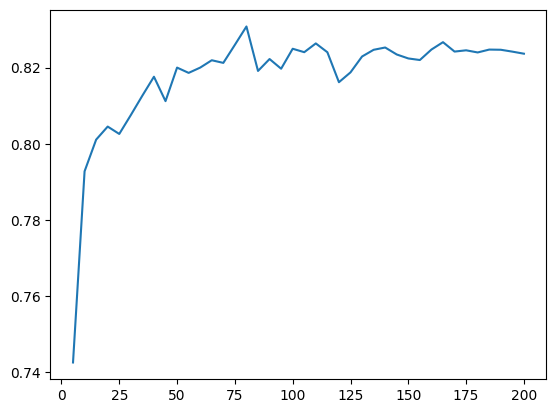

In [98]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

In [99]:
scores = []

for depth in range(5, 26, 5):
    for n in range(5, 201, 5):
        forest = RandomForestClassifier(n_estimators=n, max_depth=depth)
        forest.fit(X_train, y_train)
    
        y_pred = forest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, n, auc))

In [100]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

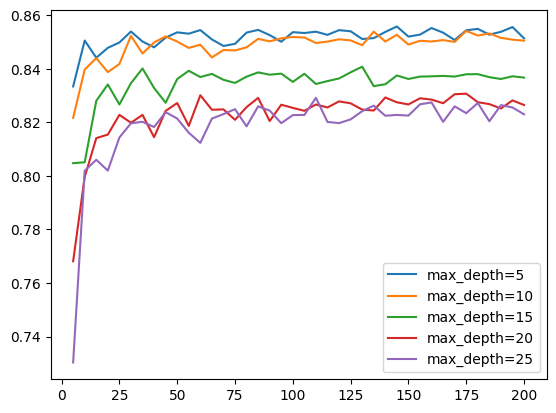

In [102]:
for depth in range(5, 26, 5):
    line_coords = df_scores[df_scores.max_depth == depth]

    plt.plot(line_coords.n_estimators, line_coords.auc, label=f'max_depth={depth}')
plt.legend()

In [106]:
best_depths = [5, 10]
min_sample_leaves = list(range(1, 5)) + list(range(10, 31, 5)) + list(range(50, 201, 50))

In [109]:
def evaluate_depth(depth, min_sample_leaves):
    scores=[]
    for m_l in min_sample_leaves:
        for n in range(5, 201, 5):
            forest = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_leaf=m_l)
            forest.fit(X_train, y_train)
        
            y_pred = forest.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            
            scores.append((m_l, n, auc))
            df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
    for m_l in min_sample_leaves:
        line_coords = df_scores[df_scores.min_samples_leaf == m_l]
    
        plt.plot(line_coords.n_estimators, line_coords.auc, label=f'.min_samples_leaf={m_l}')
    plt.legend()

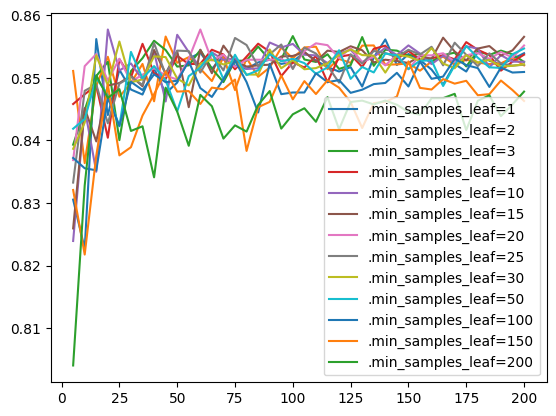

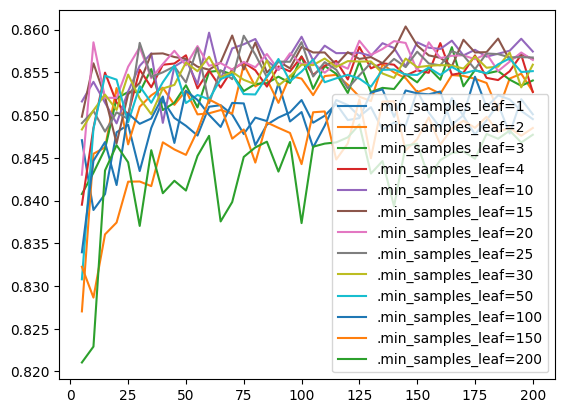

In [108]:
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

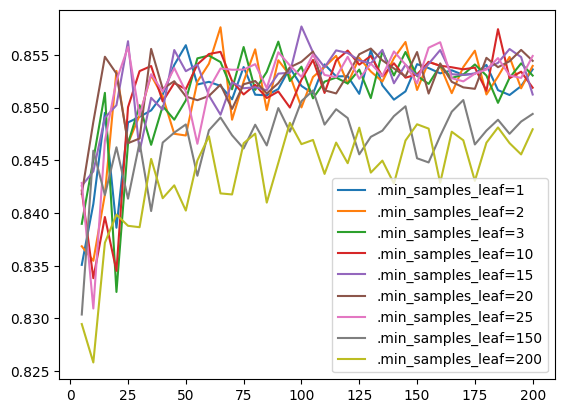

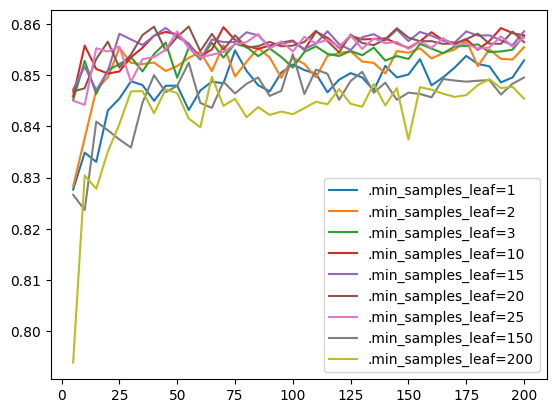

In [110]:
min_sample_leaves = [1, 2, 3, 10, 15, 20, 25, 150, 200]
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

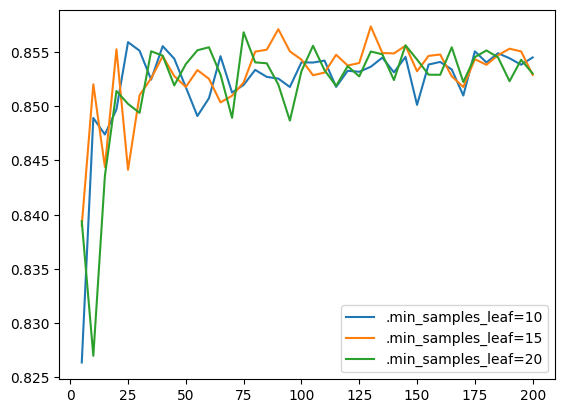

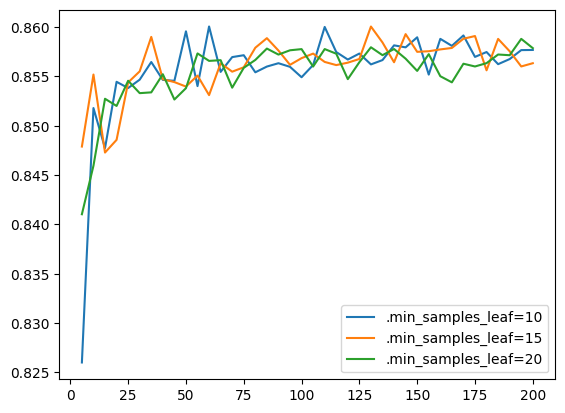

In [112]:
min_sample_leaves = [10, 15, 20]
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

In [113]:
n_estimators = 80

#### select max_features and bootstrap

In [115]:
for depth in best_depths:
    print(f"{depth}:")
    for m_f in ("sqrt", "log2", None):
        forest = RandomForestClassifier(max_depth=5, 
                                    n_estimators=n_estimators, 
                                    min_samples_leaf=15, 
                                    max_features=m_f
                                   )
        forest.fit(X_train, y_train)
            
        y_pred = forest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f"{m_f}: {auc}")

5:
sqrt: 0.8542309862044207
log2: 0.8516667521411355
None: 0.8553643776603929
10:
sqrt: 0.853100158982512
log2: 0.8516821375455151
None: 0.8561977537309605


In [116]:
for depth in best_depths:
    print(f"{depth}:")
    for b in (True, False):
        print(f"bootstrap: {b}")
        for m_f in ("sqrt", None):
            forest = RandomForestClassifier(max_depth=5, 
                                        n_estimators=n_estimators, 
                                        min_samples_leaf=15, 
                                        max_features=m_f, 
                                        bootstrap=b
                                       )
            forest.fit(X_train, y_train)
                
            y_pred = forest.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            print(f"{m_f}: {auc}")

5:
bootstrap: True
sqrt: 0.8560438996871634
None: 0.853882250371814
bootstrap: False
sqrt: 0.8517436791630341
None: 0.844238166059798
10:
bootstrap: True
sqrt: 0.8512872454997692
None: 0.8550105133596596
bootstrap: False
sqrt: 0.8552900148725575
None: 0.844238166059798


best params combinations:<br>
max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True<br>
max_depth=10, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=False

#### train final models

In [117]:
full_forest_5 = RandomForestClassifier(max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True)
full_forest_5.fit(X_full_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=80)

In [122]:
y_pred = full_forest_5.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8924782881551511)

In [119]:
forest_5 = RandomForestClassifier(max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True)
forest_5.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=80)

In [120]:
y_pred = forest_5.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8548216490880013)

In [121]:
full_forest_10 = RandomForestClassifier(max_depth=10, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=False)
full_forest_10.fit(X_full_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=15,
                       n_estimators=80)

In [124]:
y_pred = full_forest_10.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8918152924266656)

RandomForestClassifier trained on the whole set of features with paramethers: max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True has been the most accurate so far

## Gradient boosting algorithm